In [1]:
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
from helpers import count_max_consecutive_losses
import yfinance as yf
import pandas as pd
import numpy as np
import sys
import os

plt.style.use('Solarize_Light2')

FIGSIZE = (30, 10)

## **Loading & cleaning data**

In [2]:
if os.path.exists("data.csv"):
    df = pd.read_csv("data.csv", index_col=0)
else:
    # gold_ticker = yf.Ticker("GC=F")
    # gold_ticker = yf.Ticker("NQ=F")
    gold_ticker = yf.Ticker("YM=F")
    df = gold_ticker.history(period="max", interval='1h')
    df.to_csv("data.csv")

df.index = pd.to_datetime(df.index, utc=True)

df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)

In [3]:
bool_df = df.isna()
if not bool_df.loc[(bool_df['Close'] == True) | (bool_df['High'] == True) | (bool_df['Low'] == True) | (bool_df['Open'] == True)].empty:
    print("There is missing data")
    sys.exit("There is missing data")

## **Defining the Strategy (Cascading orders)**

- the PnL of n cascading orders is the follwing

$$u_1 = -1$$

$$u_2 = 0$$

n > 2:   $$u_n = \sum_{i=0}^{n-3} (3 + 2i) = n (n - 2)$$

In [4]:
# Initialize trade tracking columns
df['Position'] = 0 
df['Entry_Price'] = 0.0 
df['Exit_Price'] = 0.0 
df['PnL'] = 0.0 
df['N° Consecutive Closed Trades'] = 0.0 

trade = {}
DELTA = 9
cascade_count = 0
isLong = True
RISK = 1

position = lambda: 1 if isLong else -1
pnl = lambda: cascade_count * (cascade_count - 2) * RISK
 
def fill_trade_params(_entry_price, _idx, _isLong):
    global cascade_count
    cascade_count += 1
    trade['entry'] = _entry_price
    trade['tp'] = _entry_price + (DELTA if _isLong else -DELTA) 
    trade['sl'] = _entry_price + (-DELTA if _isLong else DELTA)
    df.loc[_idx, ['Position', 'Entry_Price']] = [1 if _isLong else -1, _entry_price]

def exit_trade(_idx, _exit_price):
    global cascade_count
    global isLong
    df.loc[_idx, [
        'PnL',
        # 'Position',
        'Exit_Price',
        'N° Consecutive Closed Trades'
    ]] = [
        pnl(),
        # position(),
        _exit_price,
        cascade_count
    ]
    cascade_count = 0
    isLong = not isLong

for idx, candel in df.iterrows():
    if cascade_count > 0:
        if (isLong and candel['Low'] <= trade['sl']) or (not isLong and candel['High'] >= trade['sl']): # sl
            exit_trade(idx, trade['sl'])
        elif (isLong and candel['High'] > trade['tp']) or (not isLong and candel['Low'] < trade['tp']): # tp
            fill_trade_params(trade['tp'], idx, isLong)
        # else: df.loc[idx, 'Position'] = position()
    else:
        fill_trade_params(candel['Close'], idx, isLong)

if cascade_count > 0:
    exit_trade(df.index[-1], df.iloc[-1]['Close'])

df['Cumulative_PnL'] = df['PnL'].cumsum()

## **Results**

- **Metrics**

In [5]:
total_trades = df[ df['PnL'] != 0]['PnL'].count()
total_pnl = df['Cumulative_PnL'].iloc[-1]
win_rate = (df[ df['PnL'] > 0]['PnL'].count() / total_trades)
average_RRR = round(df[ df['PnL'] > 0]['PnL'].mean())
expectency = (average_RRR + 1) * win_rate - 1 

strategy_stats_df = pd.DataFrame(
    np.array([[
        total_trades,
        total_pnl,
        win_rate * 100,
        average_RRR,
        expectency,
        expectency * total_trades,
        count_max_consecutive_losses(df[df['PnL'] != 0]['PnL']),
        df['N° Consecutive Closed Trades'].max()
    ]]),
    columns=[
        'Total Trades',
        'Total Profit/Loss (RR)',
        'Win rate (%)',
        'Average Risk-Reward Ratio',
        'Expectancy',
        'Expected return',
        "Max consecutive losses",
        "Max cascading"
    ],
    index=['Metrics'],
)

strategy_stats_df['Total Trades'] = strategy_stats_df['Total Trades'].astype(int)
strategy_stats_df['Max consecutive losses'] = strategy_stats_df['Max consecutive losses'].astype(int)

strategy_stats_df

,Total Trades,Total Profit/Loss (RR),Win rate (%),Average Risk-Reward Ratio,Expectancy,Expected return,Max consecutive losses,Max cascading
Metrics,3476,89675.0,12.974684,206.0,25.857595,89881.0,49,120.0


- **PnL chart**

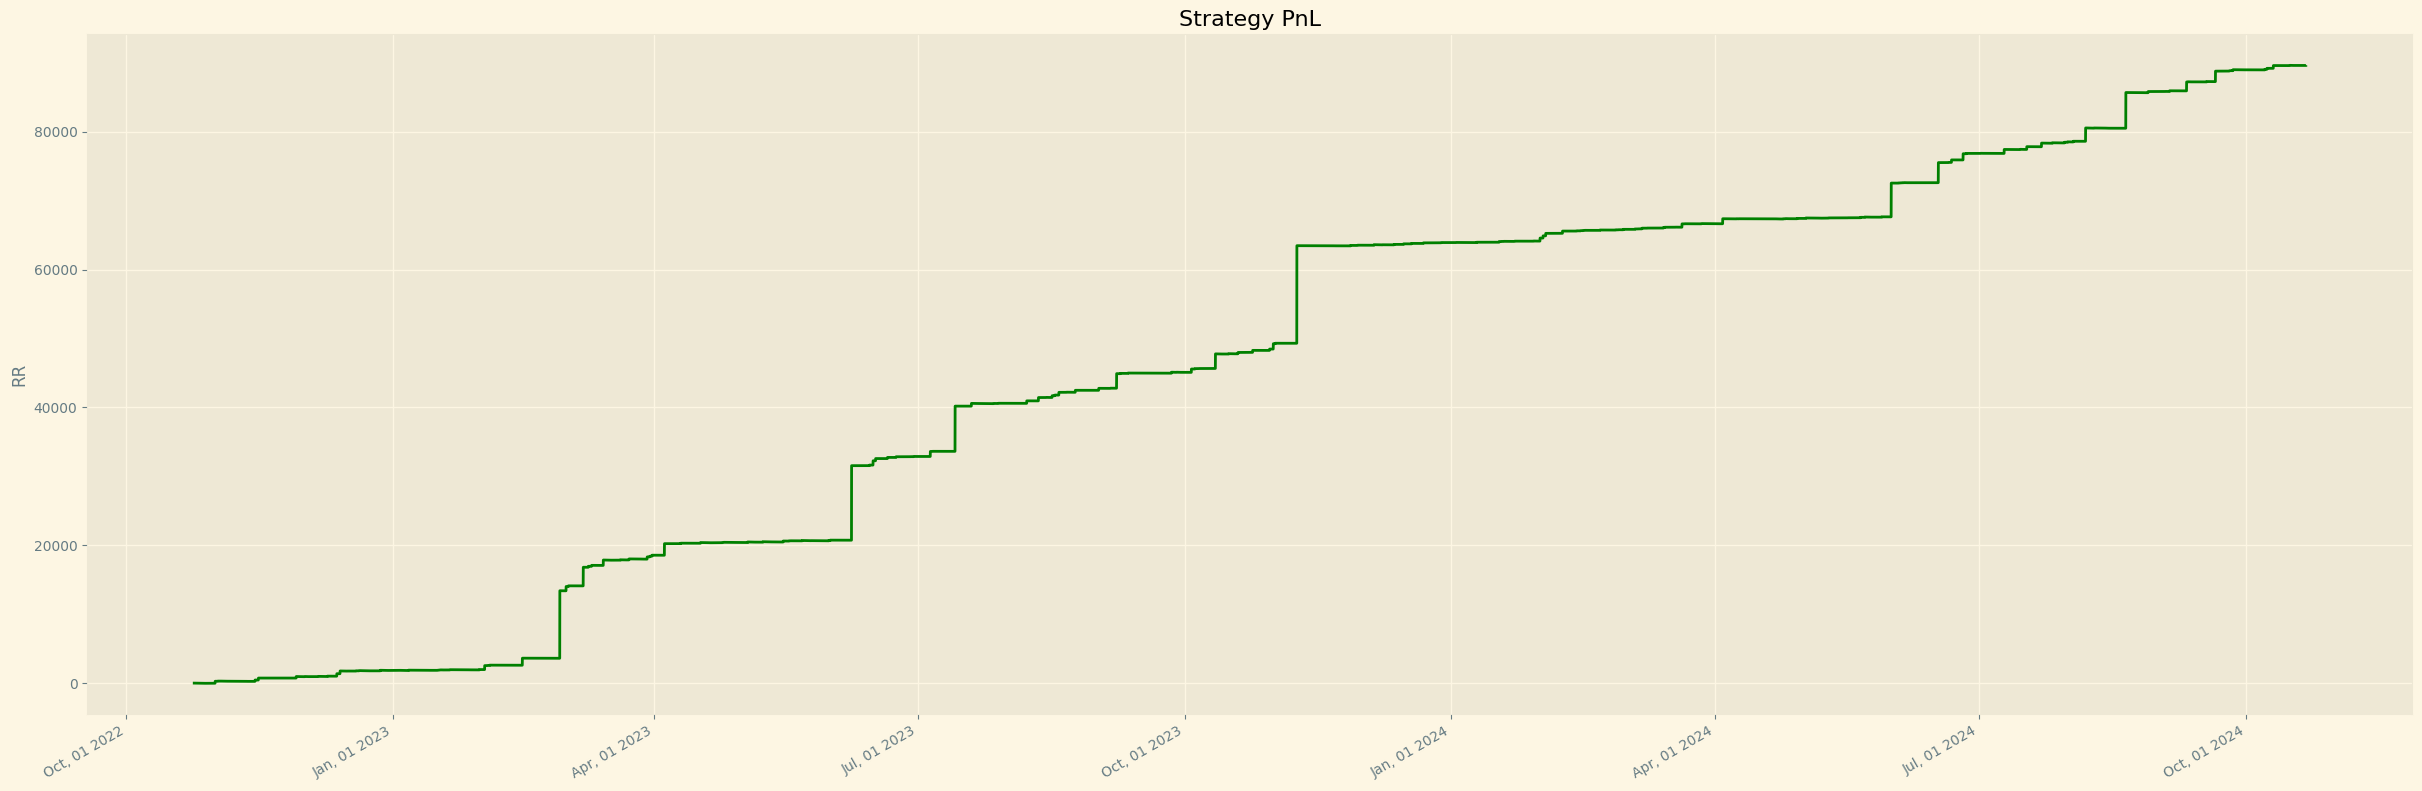

In [6]:
df['Cumulative_PnL'].plot(
        title='Strategy PnL', 
        figsize=FIGSIZE, 
        color='green', 
        xlabel='',
        ylabel='RR',
    )

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mpl_dates.DateFormatter("%b, %d %Y"))

- **Equity Drawdown chart**

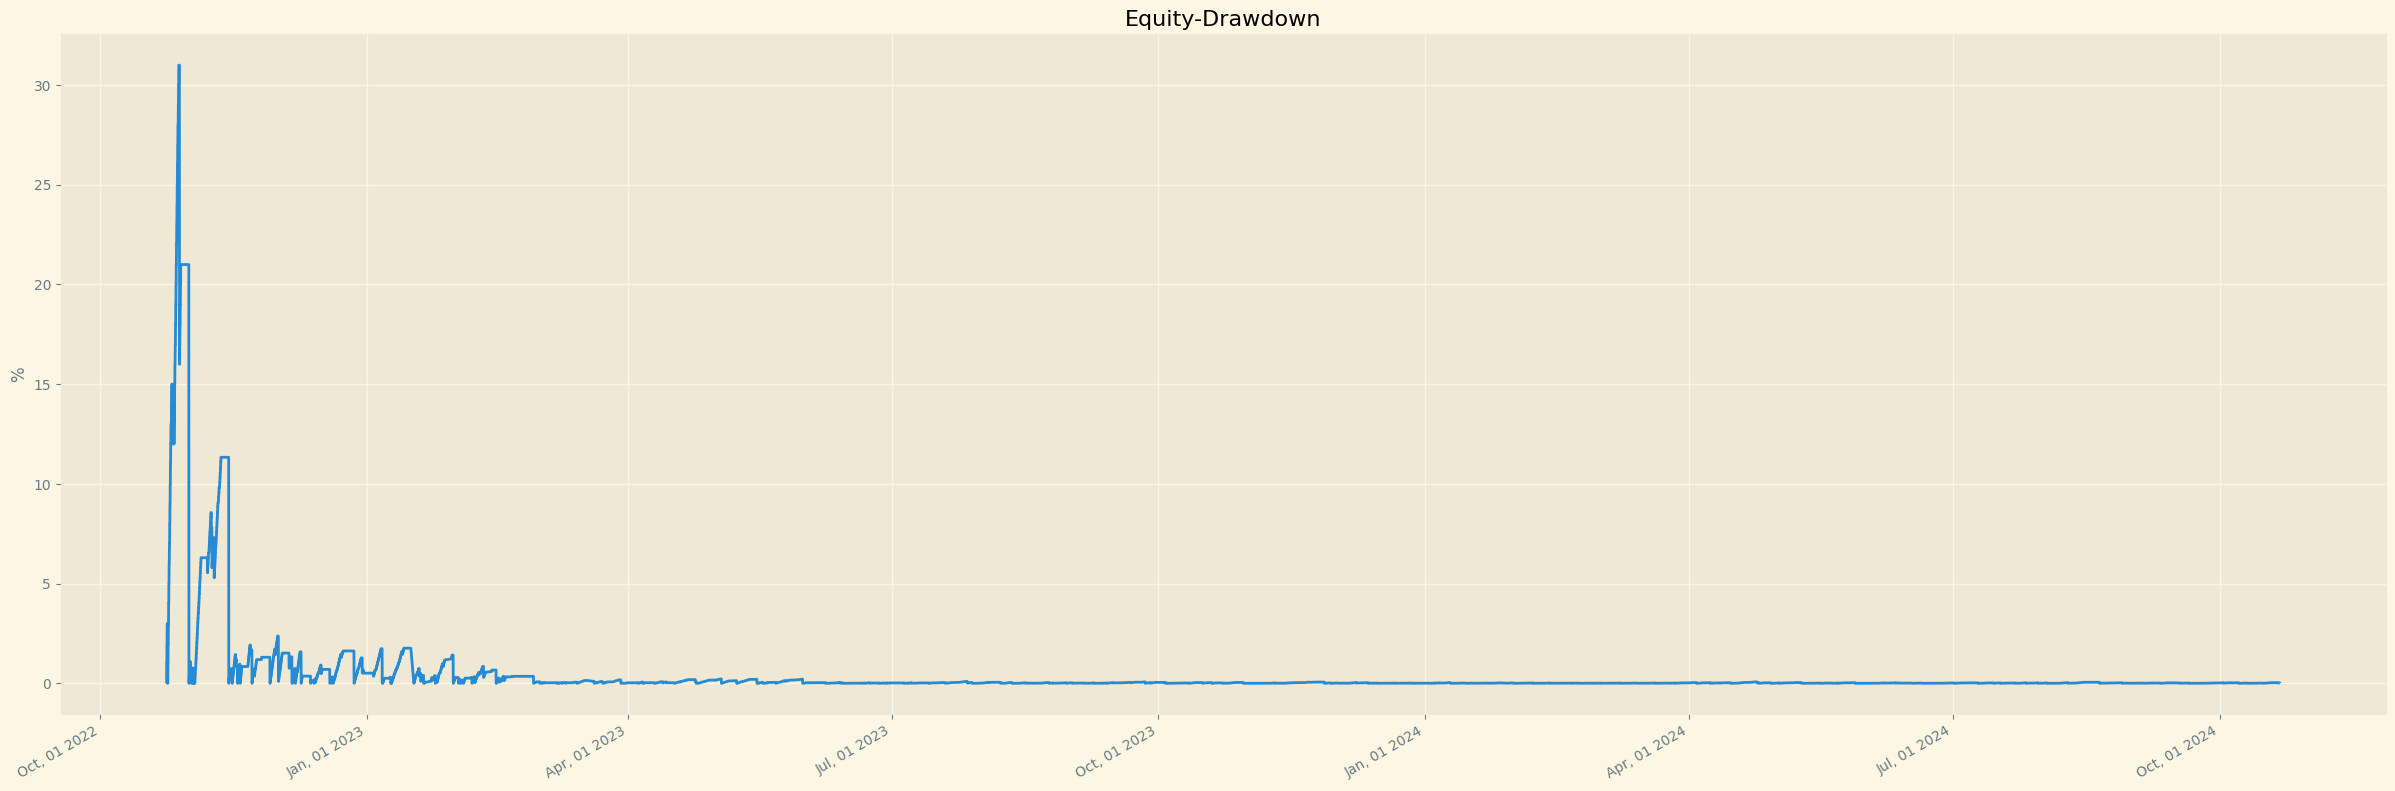

In [7]:
df['Equity'] = df['Cumulative_PnL'] + 100
df['Peak'] = df['Equity'].cummax()

df['Equity-Drawdown'] = (df['Peak'] - df['Equity']) / df['Peak']
# df['Equity-Drawdown'] = np.where(df['Peak'] == 0, abs(df['Equity']), (df['Peak'] - df['Equity']) / df['Peak'])

(df['Equity-Drawdown'] * 100).plot(
    kind='line', 
    figsize=FIGSIZE,
    title="Equity-Drawdown",
    ylabel="%",
    xlabel=''
)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mpl_dates.DateFormatter("%b, %d %Y"))

- **PnL Drawdown chart**

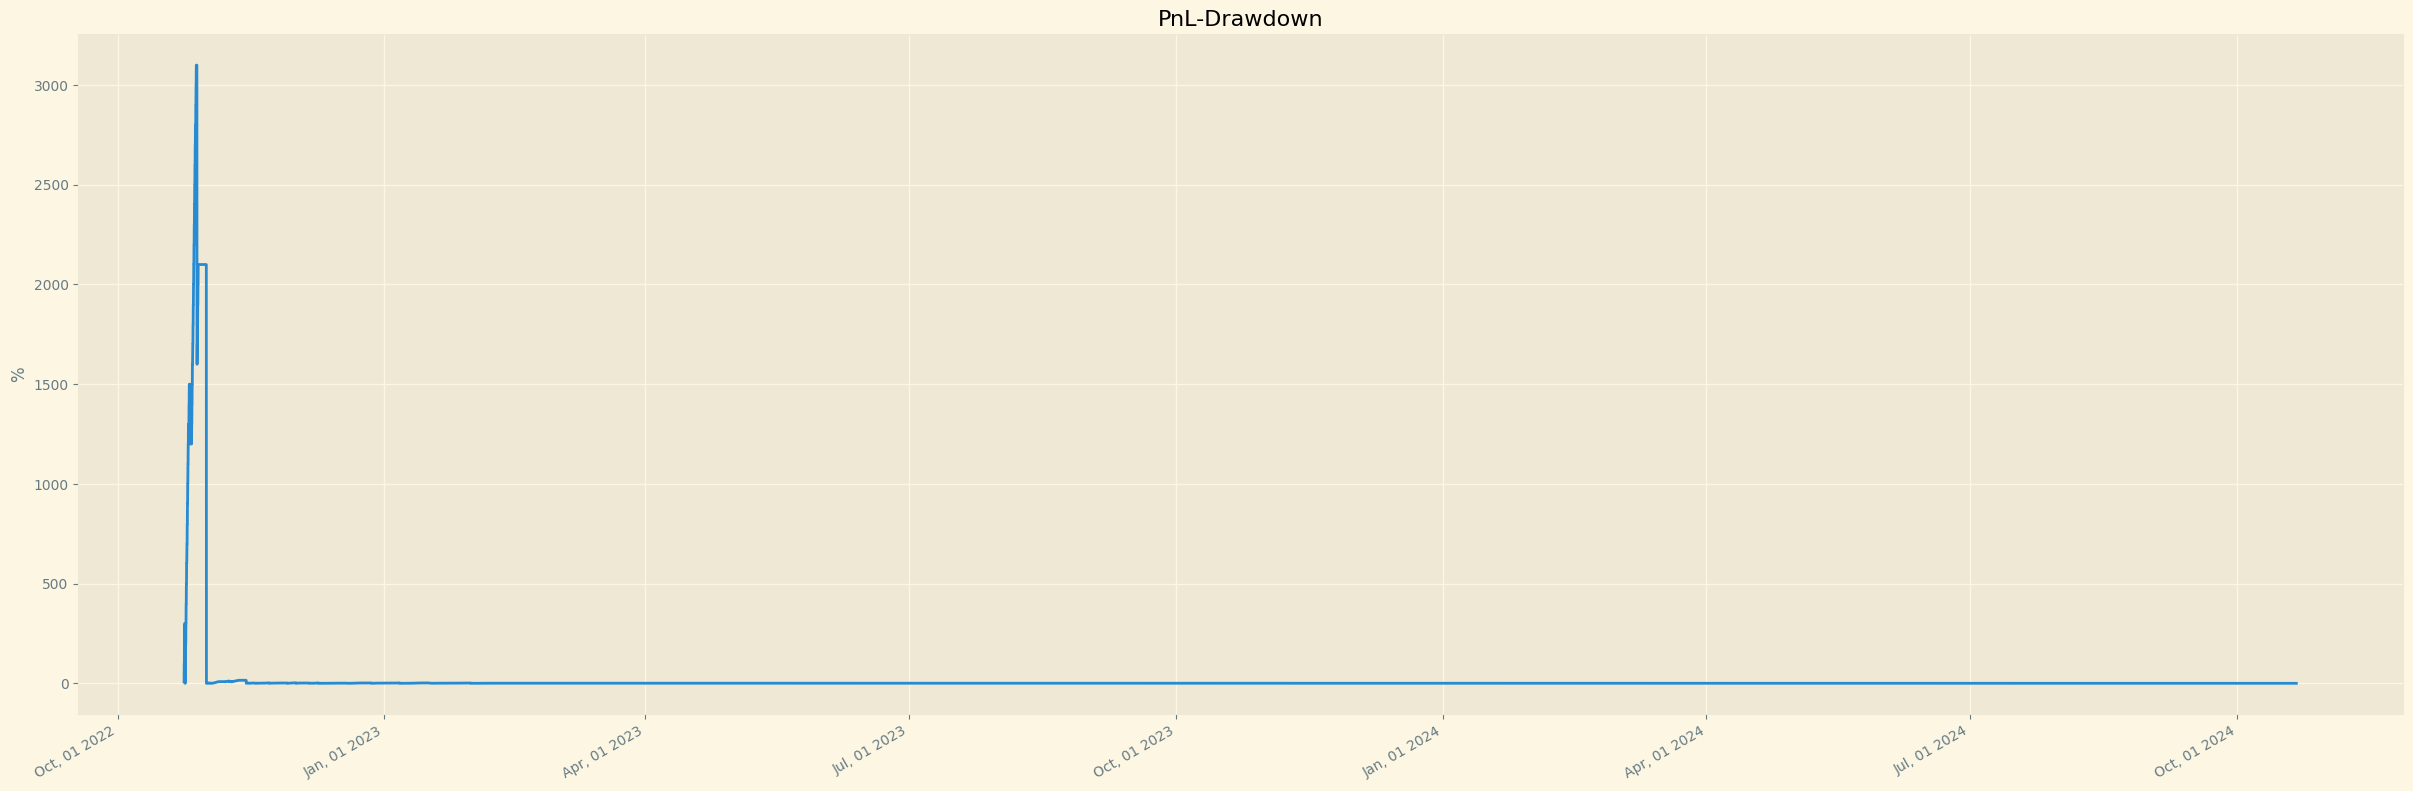

In [8]:
df['Peak'] = df['Cumulative_PnL'].cummax()

df['PnL-Drawdown'] = np.where(df['Peak'] == 0, abs(df['Cumulative_PnL']), (df['Peak'] - df['Cumulative_PnL']) / df['Peak'])

(df['PnL-Drawdown'] * 100).plot(
    kind='line', 
    figsize=FIGSIZE,
    title="PnL-Drawdown",
    ylabel="%",
    xlabel=''
)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mpl_dates.DateFormatter("%b, %d %Y"))